In [1]:
# Install detectron2
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !python3 -m pip install -U 'git+https://github.com/facebookresearch/detectron2.git@ff53992b1985b63bd3262b5a36167098e3dada02'
#python -m torch.distributed.launch main.py

/space/hotel/bachn/miniconda3/envs/m2f/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch:  1.13 ; cuda:  cu116


Run the inference with the mmdetection - basic setup

In [2]:
### clone and install Mask2Former
# !git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
# !pip install -U opencv-python
# !pip install git+https://github.com/cocodataset/panopticapi.git
# !pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

/space/hotel/bachn/implement_model/Mask2Former


  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-c_su7j4x
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-c_su7j4x
  fatal: unable to access 'https://github.com/cocodataset/panopticapi.git/': Failed to connect to 192.168.100.210 port 3128: Connection refused
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-c_su7j4x did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-c_su7j4x did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
/space/hotel

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
%cd /space/hotel/bachn/implement_model/Mask2Former
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")

# import some common libraries
import numpy as np
import cv2
import torch
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

/space/hotel/bachn/implement_model/Mask2Former


In [4]:
!pwd

/space/hotel/bachn/implement_model/Mask2Former


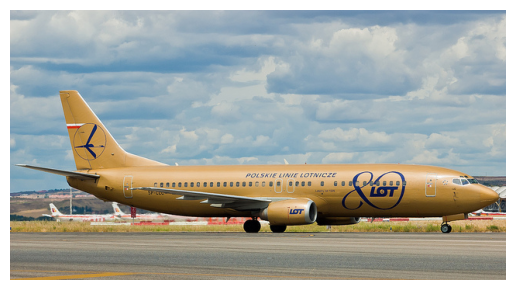

In [5]:
import matplotlib.pyplot as plt
import cv2

# Load the image
im = cv2.imread("input.jpg")

# Check if the image was loaded successfully
if im is not None:
    # Convert BGR to RGB (OpenCV loads images in BGR)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(im_rgb)
    plt.axis('off') # Hide axis
    plt.show()
else:
    print("Error: Image not loaded.")


In [6]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("configs/coco/panoptic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_100ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_f07440.pkl'
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/space/hotel/bachn/miniconda3/envs/m2f/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


WARNING [12/07 01:23:02 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [7]:
# Show panoptic/instance/semantic predictions: 
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
panoptic_result = v.draw_panoptic_seg(outputs["panoptic_seg"][0].to("cpu"), outputs["panoptic_seg"][1]).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
# cv2_imshow(np.concatenate((panoptic_result, instance_result, semantic_result), axis=0)[:, :, ::-1])

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


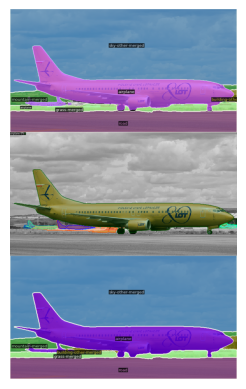

In [8]:

import matplotlib.pyplot as plt
import cv2

# Load the image
# im = cv2.imread("input.jpg")
im1 = np.concatenate((panoptic_result, instance_result, semantic_result), axis=0)[:, :, ::-1]

# Check if the image was loaded successfully
if im1 is not None:
    # Convert BGR to RGB (OpenCV loads images in BGR)
    im_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(im_rgb)
    plt.axis('off') # Hide axis
    plt.show()
else:
    print("Error: Image not loaded.")
    


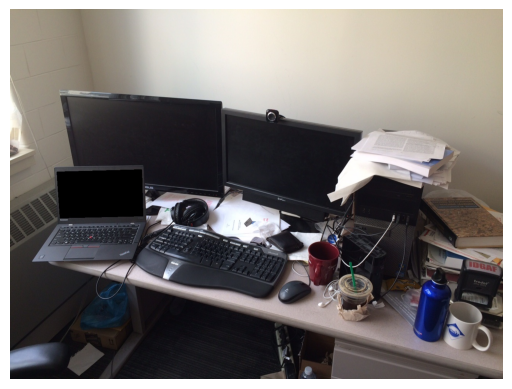

In [9]:
import matplotlib.pyplot as plt
import cv2

# Load the image
im = cv2.imread("input_2.png")

# Check if the image was loaded successfully
if im is not None:
    # Convert BGR to RGB (OpenCV loads images in BGR)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(im_rgb)
    plt.axis('off') # Hide axis
    plt.show()
else:
    print("Error: Image not loaded.")


In [10]:
outputs = predictor(im)
# Show panoptic/instance/semantic predictions: 
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
panoptic_result = v.draw_panoptic_seg(outputs["panoptic_seg"][0].to("cpu"), outputs["panoptic_seg"][1]).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
# cv2_imshow(np.concatenate((panoptic_result, instance_result, semantic_result), axis=0)[:, :, ::-1])

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


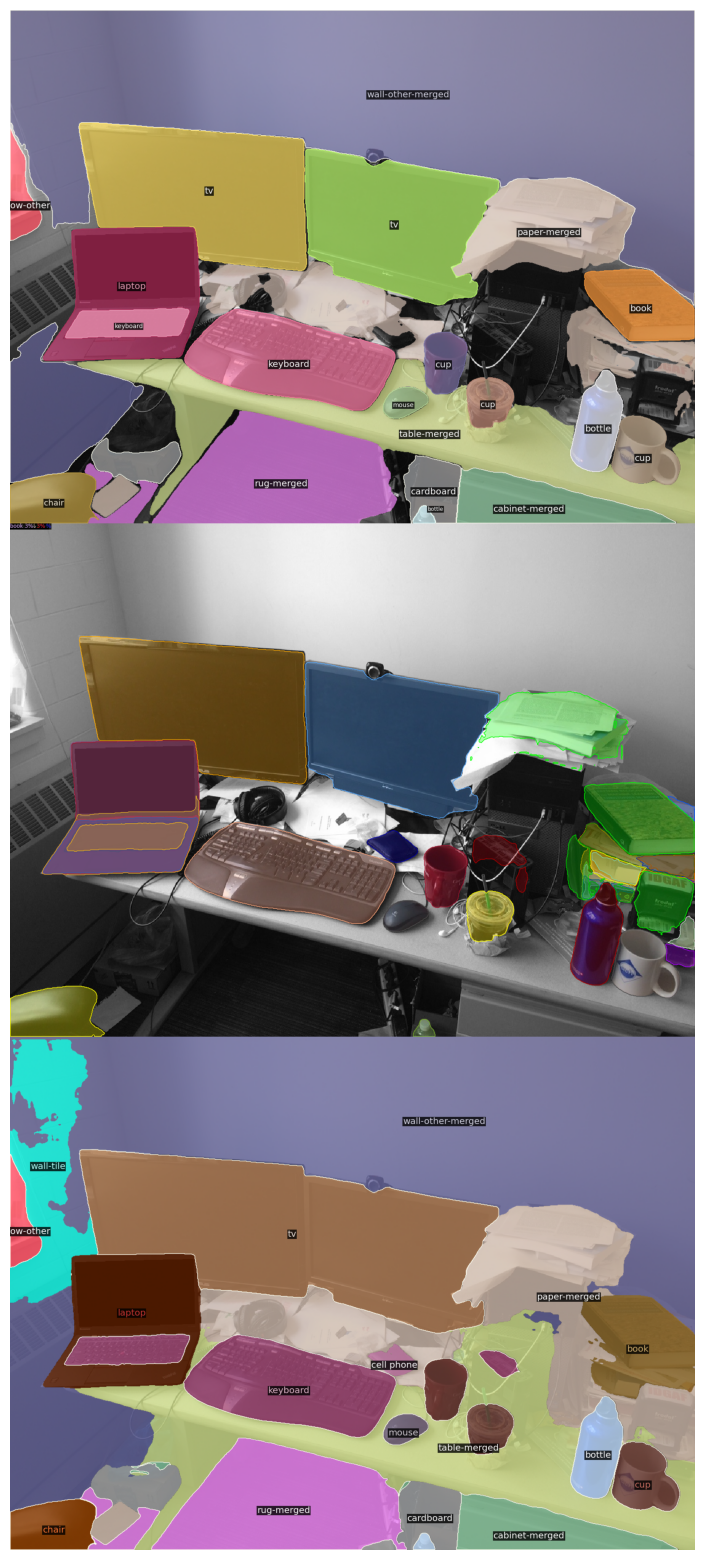

In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the image
# im = cv2.imread("input.jpg")
im2 = np.concatenate((panoptic_result, instance_result, semantic_result), axis=0)[:, :, ::-1]

# Check if the image was loaded successfully
if im2 is not None:
    # Convert BGR to RGB (OpenCV loads images in BGR)
    im_rgb = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
    
    # Create a larger figure size (adjust the width and height as needed)
    plt.figure(figsize=(20, 20))
    
    # Display the image
    plt.imshow(im_rgb)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Error: Image not loaded.")


Inference with source code re-implementation

In [17]:
%cd ../Mask2Former-Simplify

/space/hotel/bachn/implement_model/Mask2Former-Simplify


In [22]:
#free cuda space
torch.cuda.empty_cache()

In [23]:
!python -m torch.distributed.launch main.py

/space/hotel/bachn/miniconda3/envs/m2f/lib/python3.9/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
Loading config configs/Base-segmention.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
loaded pretrain mode:ckpt/mask2former_resnet50.pth
  0%|                                                     | 0/1 [00:00<?, ?it/s]/space/hotel/bachn/miniconda3/envs/m2f/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATe

In [14]:
!pwd

/space/hotel/bachn/implement_model/Mask2Former


Display all the result images

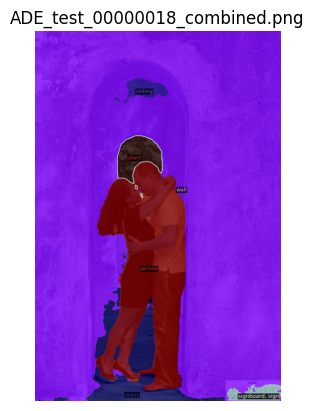

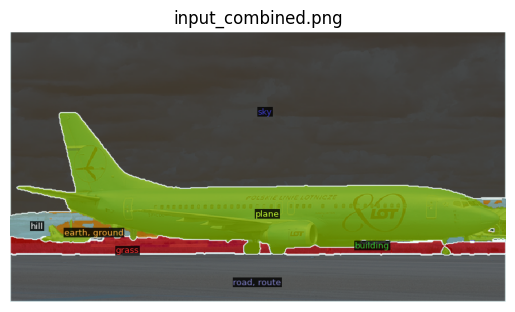

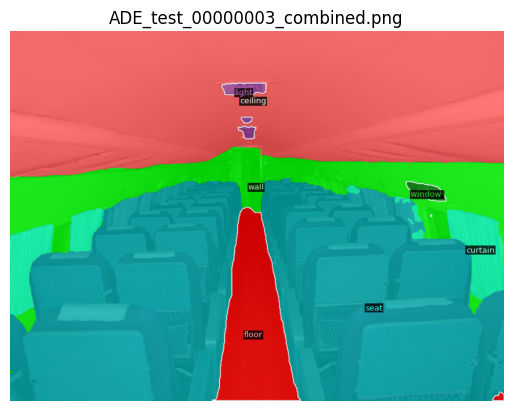

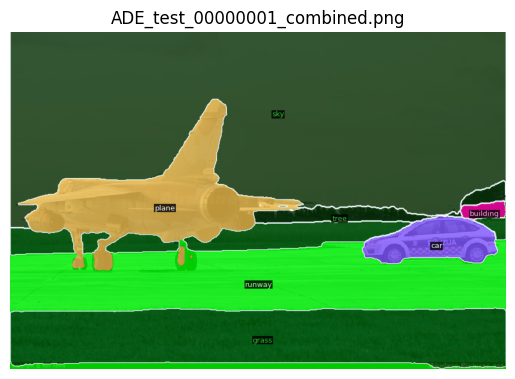

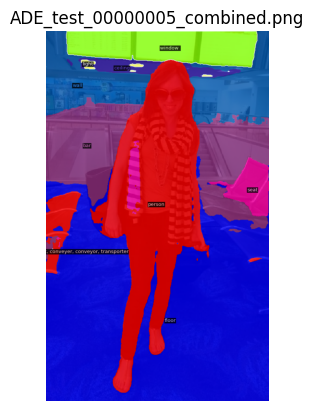

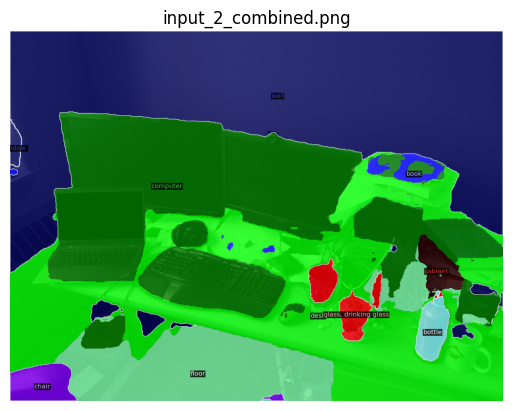

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory containing the images
image_dir = "/space/hotel/bachn/implement_model/Mask2Former-Simplify/output"

# List all files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Display each image
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    img = mpimg.imread(img_path)

    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
    plt.show()
